In [1]:
# This notebook is used to test the draculab's topology class 
# By Sergio Verduzco Flores                August 2017

# This file is supposed to be in .../draculab/tests/ , so cd before importing:
%cd ..
from draculab import *
from matplotlib import pyplot as plt
import time

/home/z/projects/draculab


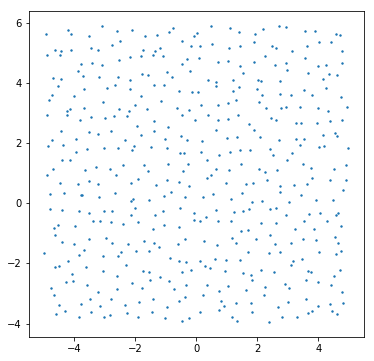

In [2]:
""" This cell is meant to test the create_group method with the 'sheet' shape and 'grid' arrangement """
topo = topology()

# Create network
net_params = {'min_delay' : 0.2, 'min_buff_size' : 4 } # parameter dictionary for the network
net = network(net_params)

# Create group of units
unit_pars = { 'init_val' : 0.5, 'function' : lambda x:None, 'type' : unit_types.source } 
geom = { 'shape':'sheet', 'extent':[10.,10.], 'center':[0.,1.], 'arrangement':'grid', 
         'rows':20, 'columns':24, 'jitter' : 0.2 }
ids = topo.create_group(net, geom, unit_pars)
xvals = [ u.coordinates[0] for u in net.units ]
yvals = [ u.coordinates[1] for u in net.units ]

figg = plt.figure(figsize=(6,6))
plt.scatter(xvals, yvals, s=2.)
plt.show()

In [3]:
""" This cell tests the topo_connect method continuing with the network in the previous cell. """

# create the spec dictionaries
conn_spec = {'connection_type' : 'divergent',
             #'number_of_connections' : 20,
             #'mask' : {'rectangular':{'lower_left':[-1.,-4.], 'upper_right':[3.,-1.5]}}, 
             'mask' : {"annular" : {"inner_radius": 2., 'outer_radius':5.}},
             #'mask' : {'circular' : {'radius' : 3}},
             'kernel' : 1., 
             #'kernel' : {'gaussian':{'p_center':.2, 'sigma':3.}},
             #'kernel' : {'linear' : {'c' : 1., 'a' : .3}},
             'delays' : {'linear' : {'c':0.1, 'a':0.1}},
             'weights' : {'linear' : {'c':5., 'a':1.}},
             'edge_wrap' : True,
             'boundary' : {'center' : geom['center'], 'extent' : geom['extent']},
            }
syn_spec = {'type' : synapse_types.static, 'init_w' : 0.2 }

# connect
topo.topo_connect(net, ids, ids, conn_spec, syn_spec)

<IPython.core.display.Javascript object>


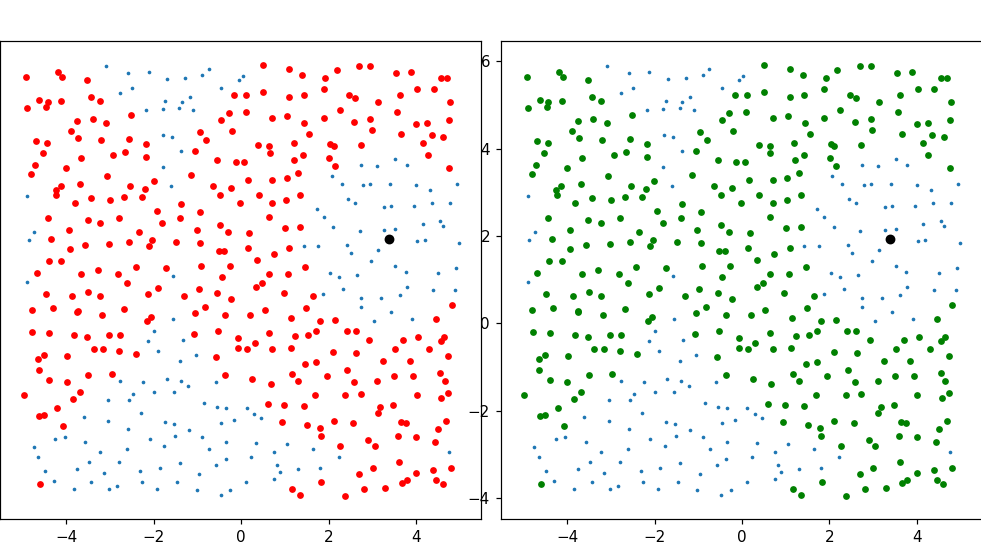

In [4]:
# visualizing the connections 
from matplotlib.animation import FuncAnimation
%matplotlib notebook
# The 'notebook' backend is compatible with FuncAnimation

# flattening net.syns
all_syns = []
for syn_list in net.syns:
    all_syns += syn_list
    
# getting a list with the coordinates of all units
all_coords = [u.coordinates for u in net.units]

fig = plt.figure(figsize=(9,5))
ax1 = fig.add_axes([0.0, 0.01, .49, 0.95], frameon=True, aspect=1)
ax2 = fig.add_axes([0.51, 0.01, .49, 0.95], frameon=True, aspect=1)
ax1.plot(xvals, yvals, 'c.')
ax2.plot(xvals, yvals, 'c.')

# At each frame we'll visualize the connections arising from a single unit
def update(frame): 
    u = (frame*1)%480 # unit we'll visualize
    
    # getting targets of projections from the unit 'u'
    targets = [syn.postID for syn in all_syns if syn.preID == u]
    tar_coords = [ all_coords[t] for t in targets ]
    #coords = [ unit.coordinates for unit in [net.units[idx] for idx in targets] ]
    tar_xcoords = [c[0] for c in tar_coords]
    tar_ycoords = [c[1] for c in tar_coords]
    ax1.clear()
    #ax.plot(xvals, yvals, 'c.')
    #ax.plot(xcoords, ycoords, 'ro', net.units[u].coordinates[0], net.units[u].coordinates[1], 'ko')
    ax1.scatter(xvals, yvals, s=2)
    ax1.scatter(net.units[u].coordinates[0], net.units[u].coordinates[1], s=30, c='black')
    ax1.scatter(tar_xcoords, tar_ycoords, s=12, c="red")
    
    
    # getting units that project to unit 'u'
    sources = [ syn.preID for syn in net.syns[u] ]
    sour_coords = [ all_coords[s] for s in sources ]
    sour_xcoords = [ c[0] for c in sour_coords ]
    sour_ycoords = [ c[1] for c in sour_coords ]
    ax2.clear()
    ax2.scatter(xvals, yvals, s=2)
    ax2.scatter(net.units[u].coordinates[0], net.units[u].coordinates[1], s=30, c='black')
    ax2.scatter(sour_xcoords, sour_ycoords, s=12, c="green")
    
    return ax1,ax2,

animation = FuncAnimation(fig, update, interval=15, blit=True)
plt.show()

In [5]:
# If you use this, don't call FuncAnimation above
from ipywidgets import interact
interact(update, frame=(1,480))

interactive(children=(IntSlider(value=240, description='frame', max=480, min=1), Output()), _dom_classes=('widget-interact',))

<function __main__.update>